In [39]:
%%writefile requirements.txt
streamlit
torch
transformers
sentencepiece
pandas
numpy
sumy
rouge
scikit-learn
matplotlib
seaborn
pyngrok

Overwriting requirements.txt


In [46]:
#pip install -r requirements.txt


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bornaetminan/amazon-fine-reviews-cleaned-ml-ready")

print("Path to dataset files:", path)

100%|██████████| 345M/345M [00:03<00:00, 92.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bornaetminan/amazon-fine-reviews-cleaned-ml-ready/versions/1


In [47]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns


In [49]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer


In [50]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration


In [51]:
#!ls -R {path}

/root/.cache/kagglehub/datasets/bornaetminan/amazon-fine-reviews-cleaned-ml-ready/versions/1:
amazon_reviews_full_clean.csv  amazon_reviews_ml_ready.csv  database.sqlite


In [52]:
import os

In [10]:
df = pd.read_csv(os.path.join(path, "amazon_reviews_full_clean.csv"))
df.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,clean_text,clean_summary,char_count,word_count,avg_word_length,helpfulness_ratio,review_date,review_year,review_month,review_day,sentiment,sentiment_label
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,i have bought several of the vitality canned d...,good quality dog food,259,48,5.395833,0.50,2011-04-27,2011,4,27,positive,2
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,product arrived labeled as jumbo salted peanut...,not as advertised,183,31,5.903226,0.00,2012-09-07,2012,9,7,negative,0
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,this is a confection that has been around a fe...,delight says it all,484,92,5.260870,0.50,2008-08-18,2008,8,18,positive,2
3,B000UA0QIQ,A395BORC6FGVXV,3,3,2,if you are looking for the secret ingredient i...,cough medicine,212,41,5.170732,0.75,2011-06-13,2011,6,13,negative,0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,great taffy at a great price there was a wide ...,great taffy,132,27,4.888889,0.00,2012-10-21,2012,10,21,positive,2


In [53]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import os

# Load data
df = pd.read_csv(os.path.join(path, "amazon_reviews_full_clean.csv"))

# Keep required columns
df = df[['clean_text', 'clean_summary']].dropna()

# Rename for consistency
df.rename(columns={'clean_text': 'text', 'clean_summary': 'summary'}, inplace=True)

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', '', text)
    return text

df['text'] = df['text'].apply(clean_text)
df['summary'] = df['summary'].apply(clean_text)

# Limit text length (important for transformers)
df = df[df['text'].str.split().str.len() < 400]

# Train-test split
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42
)

# Save
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)

print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

Train size: (311840, 2)
Test size: (77960, 2)


In [54]:
display(train_df.head())

,text,summary
123167,what a rip off we opened the bag and a day lat...,beef jerky goes bad
387206,this product has authentic color and flavors y...,knorr usa goulash recipe mix
29332,i like this brand because it is well flavoreds...,good flavor
217967,i probably wont be ordering this from the inte...,very nice flavored pop
246531,i am addicted to this tea maybe because as an ...,simply the best tasting tea i have ever drank


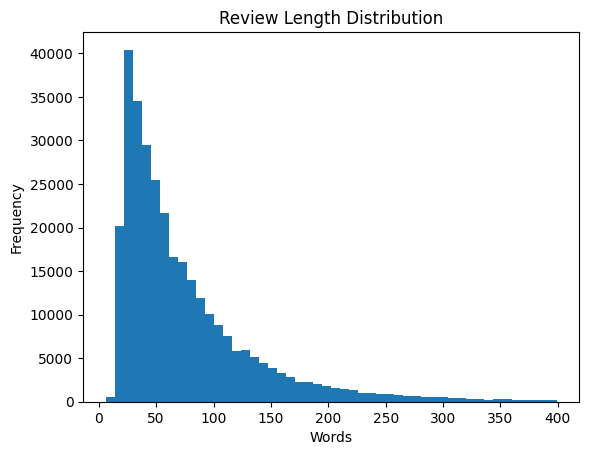

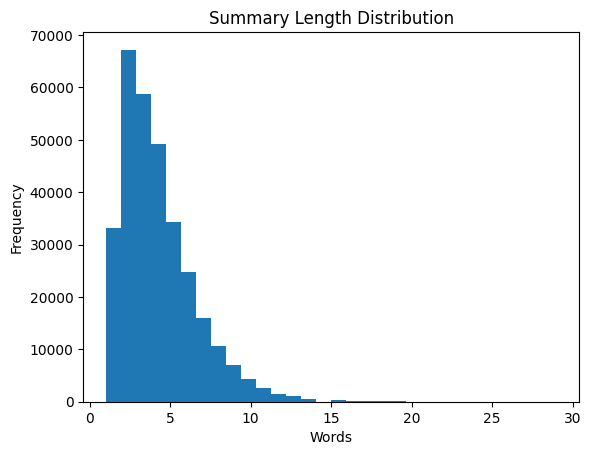

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("train.csv")

df['text_len'] = df['text'].apply(lambda x: len(x.split()))
df['summary_len'] = df['summary'].apply(lambda x: len(x.split()))

plt.hist(df['text_len'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

plt.hist(df['summary_len'], bins=30)
plt.title("Summary Length Distribution")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()


In [56]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

def textrank_summary(text, sentences=2):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences)
    return " ".join(str(s) for s in summary)


In [57]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

device = "cpu"

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

def t5_summary(text):
    if not isinstance(text, str):
        return ""

    input_text = "summarize: " + text[:1000]

    input_ids = tokenizer.encode(
        input_text,
        return_tensors="pt",
        max_length=512,
        truncation=True
    ).to(device)

    output = model.generate(
        input_ids,
        max_length=40,
        num_beams=4,
        early_stopping=True
    )

    return tokenizer.decode(output[0], skip_special_tokens=True)


In [58]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [59]:
import pandas as pd
from rouge import Rouge

test_df = pd.read_csv("test.csv")
rouge = Rouge()

def evaluate(model_func, n=30):
    scores = []
    for i in range(n):
        pred = model_func(test_df.iloc[i]['text'])
        ref = test_df.iloc[i]['summary']
        score = rouge.get_scores(pred, ref)[0]['rouge-l']['f']
        scores.append(score)
    return sum(scores) / len(scores)

print("TextRank ROUGE-L:", evaluate(textrank_summary))
print("T5 ROUGE-L:", evaluate(t5_summary))


TextRank ROUGE-L: 0.07561166740537265
T5 ROUGE-L: 0.0951384493984737


In [60]:
%%writefile app.py
import streamlit as st
from transformers import T5Tokenizer, T5ForConditionalGeneration
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

# ===============================
# Page Config
# ===============================
st.set_page_config(
    page_title="Amazon Review Summarizer",
    page_icon="🛒",
    layout="centered"
)

# ===============================
# CSS Styling (FIXED)
# ===============================
st.markdown(
    """
    <style>
    .stApp {
        background: linear-gradient(to right, #f5f7fa, #c3cfe2);
        font-family: 'Segoe UI', sans-serif;
    }

    h1 {
        text-align: center;
        color: #0d47a1;
    }

    .subtitle {
        text-align: center;
        color: #37474f;
        margin-bottom: 25px;
    }

    .summary-box {
        background-color: #ffffff;
        padding: 20px;
        border-radius: 14px;
        box-shadow: 0px 6px 15px rgba(0,0,0,0.12);
        margin-top: 20px;
        font-size: 16px;
    }

    .footer {
        text-align: center;
        color: gray;
        margin-top: 40px;
        font-size: 14px;
    }

    footer {
        visibility: hidden;
    }
    </style>
    """,
    unsafe_allow_html=True
)

# ===============================
# Title
# ===============================
st.markdown("<h1>🛒 Amazon Review Text Summarization 🤖</h1>", unsafe_allow_html=True)
st.markdown(
    "<div class='subtitle'>Summarize Amazon product reviews using NLP models</div>",
    unsafe_allow_html=True
)

# ===============================
# Input
# ===============================
text = st.text_area(
    "✍️ Enter Review Text",
    height=180,
    placeholder="Paste your Amazon product review here..."
)

model_choice = st.selectbox(
    "🤖 Choose Model",
    ["TextRank", "T5"]
)

# ===============================
# Load T5
# ===============================
@st.cache_resource
def load_t5():
    tokenizer = T5Tokenizer.from_pretrained("t5-small")
    model = T5ForConditionalGeneration.from_pretrained("t5-small")
    return tokenizer, model

# ===============================
# Generate Summary
# ===============================
if st.button("🚀 Generate Summary"):
    if text.strip() == "":
        st.warning("⚠️ Please enter review text first.")
    else:
        with st.spinner("🧠 Generating summary..."):
            if model_choice == "TextRank":
                parser = PlaintextParser.from_string(text, Tokenizer("english"))
                summarizer = TextRankSummarizer()
                summary_sentences = summarizer(parser.document, 2)
                summary = " ".join(str(s) for s in summary_sentences)
            else:
                tokenizer, model = load_t5()
                input_text = "summarize: " + text[:1000]
                input_ids = tokenizer.encode(
                    input_text,
                    return_tensors="pt",
                    max_length=512,
                    truncation=True
                )
                output = model.generate(input_ids, max_length=40)
                summary = tokenizer.decode(output[0], skip_special_tokens=True)

        st.markdown(
            f"""
            <div class="summary-box">
                <h4>📌 Summary</h4>
                {summary}
            </div>
            """,
            unsafe_allow_html=True
        )

# ===============================
# Footer
# ===============================
st.markdown(
    """
    <div class="footer">
        <hr>
        Developed by <b>javaria Siddiqui</b> ❤️ <br>
        NLP Project | Streamlit • TextRank • T5 🤖
    </div>
    """,
    unsafe_allow_html=True
)

Overwriting app.py


In [61]:
!ngrok authtoken XXXXX

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [62]:
!ngrok

ngrok - tunnel local ports to public URLs and inspect traffic

USAGE:
  ngrok [command] [flags]

COMMANDS: 
  api             CLI to api.ngrok.com
  completion      generates shell completion code for bash or zsh
  config          update or migrate ngrok's configuration file
  credits         prints author and licensing information
  help            help about any command
  http            start an HTTP tunnel
  service         run and control ngrok as a background service
  start           start endpoints in the config file by name
  tcp             start a TCP tunnel
  tls             start a TLS endpoint
  update          update ngrok to the latest version
  version         print the version string

EXAMPLES: 
# forward http traffic from assigned public URL to local port 80
ngrok http 80
# port 8080 available at baz.ngrok.dev
ngrok http --url baz.ngrok.dev 8080
# tunnel arbitrary TCP traffic to port 22
ngrok tcp 22
# secure your app with oauth
ngrok http 80 --oauth=google --oauth-al

In [63]:
from pyngrok import ngrok

ngrok.set_auth_token("38INf7A7ntwgQ3FxKqVpwB7LF0X_2atGSEqxezbawN1xNii9f")



In [64]:
!streamlit run app.py &>/content/logs.txt &


In [65]:
public_url = ngrok.connect(addr='8501', proto='http')
print(f'Streamlit App URL: {public_url}')

Streamlit App URL: NgrokTunnel: "https://transpadane-unprecocious-man.ngrok-free.dev" -> "http://localhost:8501"
